# CA Project （Machine Learning in Python） Team 6

### CNN implementation for fruits classification

### 1: Import Libraries and check tensorflow version

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
print(tf.__version__)


2.7.0


## Prepare data

### 2: Get all the images paths and its labels and Store them in pandas dataframe

In [2]:
IMAGE_HEIGHT=64
IMAGE_WIDTH=64
BATCH_SIZE=32

def get_pathframe(path):
  filenames = os.listdir(path)
  categories = []
  paths = []
  for filename in filenames:
    paths.append(path+'/'+filename)
    category = filename.split('_')[0]
    if category == 'apple':
      categories.append(0)
    elif category == 'banana':
      categories.append(1)
    elif category == 'orange':
        categories.append(2)
    else:
        categories.append(3)

  df = pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths': paths
  })
  return df


### 3: Check generated dataframe for training data

In [3]:
df = get_pathframe("train")
df.head()

,filename,category,paths
0,apple_1.jpg,0,train/apple_1.jpg
1,apple_10.jpg,0,train/apple_10.jpg
2,apple_11.jpg,0,train/apple_11.jpg
3,apple_12.jpg,0,train/apple_12.jpg
4,apple_13.jpg,0,train/apple_13.jpg


### 4: Check the shape of image and make sure the number is correct

In [4]:
df.shape

(240, 3)

### 5: Load each image , normalization and resize it to desired shape (64,64)

In [5]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image


###  6: Convert each data and labels to tensor

In [6]:
def convert_to_tensor(df):
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),4) 
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

In [7]:
X, Y = convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)


Shape of X in data: <MapDataset shapes: (64, 64, 3), types: tf.float32>
Shape of Y in data: <TensorSliceDataset shapes: (4,), types: tf.float32>


### 7: Display some the images in training dataset

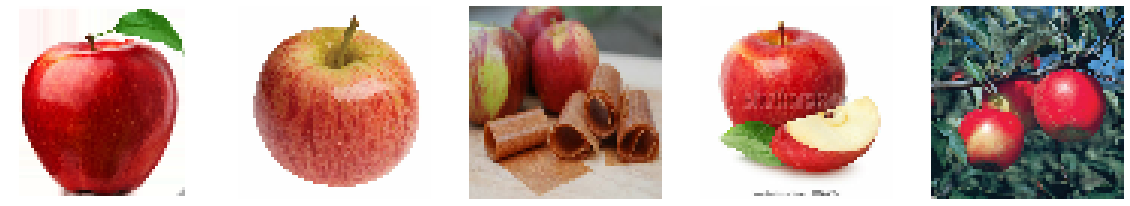

In [8]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for image, ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')


imagesls = []
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)


### 8: Generate training dataset

In [9]:
dataset_train = tf.data.Dataset.zip((X, Y)).shuffle(buffer_size=20).batch(BATCH_SIZE)

### 9: Check generated dataframe for testing dataset

In [10]:
df2 = get_pathframe("test")
df2.head()


,filename,category,paths
0,apple_77.jpg,0,test/apple_77.jpg
1,apple_78.jpg,0,test/apple_78.jpg
2,apple_79.jpg,0,test/apple_79.jpg
3,apple_80.jpg,0,test/apple_80.jpg
4,apple_81.jpg,0,test/apple_81.jpg


### 10: Check the number of image in the testing dataset

In [11]:
df2.shape

(60, 3)

In [12]:
X1, Y1 = convert_to_tensor(df2)
print("Shape of X in data:", X1)
print("Shape of Y in data:", Y1)


Shape of X in data: <MapDataset shapes: (64, 64, 3), types: tf.float32>
Shape of Y in data: <TensorSliceDataset shapes: (4,), types: tf.float32>


### 11: Display some the images in testing dataset

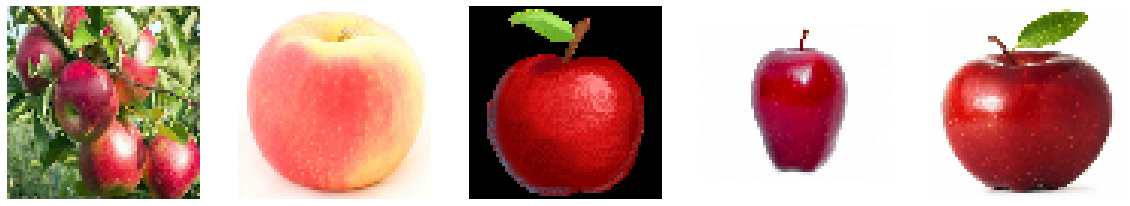

In [13]:
imagesls = []
for n, image in enumerate(X1.take(5)):
  imagesls.append(image)

plotimages(imagesls)


In [14]:
dataset_test = tf.data.Dataset.zip((X1, Y1)).batch(BATCH_SIZE)

## <mark>Basic Model<mark>

#### Firstly, for experiment,we just created a basic model with 2 convolutional layers to test its accuracy and tend to improve the model based on the result.

In [15]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, Dropout
def My_CNNmodel():
    
    model = tf.keras.models.Sequential()

# convolutional layer
    model.add(Conv2D(25, kernel_size=(3, 3),
                     activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
# convolutional layer
    model.add(Conv2D(50, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
# flatten output of conv
    model.add(Flatten())
# hidden layer
    model.add(Dense(128, activation='relu'))
# output layer
    model.add(Dense(units=4, activation='softmax'))

# compiling
    model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')

    return model


### 1: Check model summary

In [16]:
model = My_CNNmodel()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 25)        700       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 50)        11300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 50)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9800)              0         
                                                                 
 dense (Dense)               (None, 128)               1

## 2: Train model

In [17]:
history=model.fit(dataset_train,epochs=20,validation_data=dataset_test)

Epoch 1/20
8/8 [==============================] - 1s 96ms/step - loss: 3.0820 - accuracy: 0.3125 - val_loss: 1.3903 - val_accuracy: 0.3000
Epoch 2/20
8/8 [==============================] - 1s 80ms/step - loss: 1.3376 - accuracy: 0.3042 - val_loss: 1.3813 - val_accuracy: 0.3000
Epoch 3/20
8/8 [==============================] - 1s 82ms/step - loss: 1.3818 - accuracy: 0.4000 - val_loss: 1.3811 - val_accuracy: 0.3000
Epoch 4/20
8/8 [==============================] - 1s 86ms/step - loss: 1.3797 - accuracy: 0.3542 - val_loss: 1.3708 - val_accuracy: 0.5167
Epoch 5/20
8/8 [==============================] - 1s 85ms/step - loss: 1.3693 - accuracy: 0.2500 - val_loss: 1.3218 - val_accuracy: 0.5667
Epoch 6/20
8/8 [==============================] - 1s 86ms/step - loss: 1.3426 - accuracy: 0.5417 - val_loss: 1.2073 - val_accuracy: 0.5667
Epoch 7/20
8/8 [==============================] - 1s 86ms/step - loss: 1.2192 - accuracy: 0.5792 - val_loss: 1.0429 - val_accuracy: 0.6833
Epoch 8/20
8/8 [===========

<ipython-input-18-a160c7a717b0>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1),
<ipython-input-18-a160c7a717b0>:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(


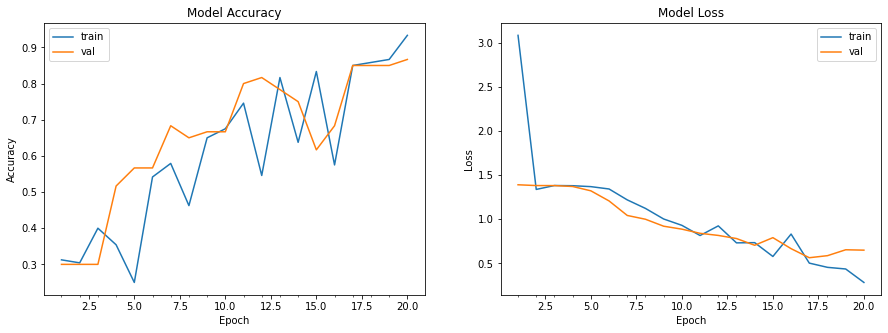

In [18]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc])+1),
                model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc])+1),
                model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1),
                      len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss'])+1),
                model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1),
                model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(
        1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


plot_model_history(history)


### 3: Findings:

#### 1: We can see from the plots above, The model accuracy and model loss are stable, and the model accuracy shows an upward trend. Therefore, we consider appropriately adding more EPOCHS when training the improved model.  

#### 2: From the Model Accuracy plot, it can indicate the model is a bit overfitted, there are certain ways to overcome it, for example: Expanding the dataset and Adding dropout layers. we will try to overcome the problem in our improved model



### 4: Evaluation

2/2 [==============================] - 0s 18ms/step - loss: 0.6500 - accuracy: 0.8667
Test: accuracy = 0.866667  ;  loss = 0.650039 


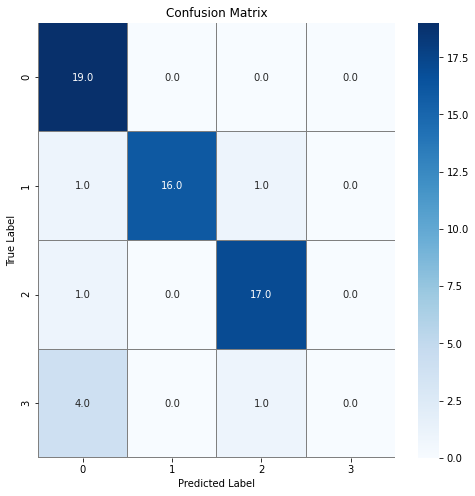

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Predict the values from the validation dataset
loss, accuracy = model.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
y_pred = model.predict(dataset_test)
y_p = np.where(y_pred > 0.5, 1, 0)
test_data = dataset_test.unbatch()
y_g = []
for image, label in test_data:
  y_g.append(label.numpy())

confusion_mtx = confusion_matrix(np.asarray(y_g).argmax(
    axis=1), np.asarray(y_p).argmax(axis=1))
# confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,
            cmap="Blues", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## <mark>Improved Model<mark>

#### 1: In our improved model, we tried to add 1 more convolution layer and modify the parameters in the convolution layers. We also use the ' padding' parameter to make the input dimension and output dimension of the convolution layer consistent.

#### 2: To overcome the overfitted problem,we added dropout layers in our improved model

#### 3: when training the model,we increased the epochs from 20 to 25

In [20]:
def My_CNNmodel2():
    model = tf.keras.models.Sequential()
    model.add(InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

# 1st conv block
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
# 2nd conv block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
# 3rd conv block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
# ANN
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.5))
# output layer
    model.add(Dense(units=4, activation='softmax'))

# compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model

In [21]:
model2 = My_CNNmodel2()
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)       

## Train the model with more epochs

In [22]:
history2=model2.fit(dataset_train,epochs=25,validation_data=dataset_test)

Epoch 1/25
8/8 [==============================] - 1s 91ms/step - loss: 5.4796 - accuracy: 0.1958 - val_loss: 1.3468 - val_accuracy: 0.3000
Epoch 2/25
8/8 [==============================] - 1s 79ms/step - loss: 1.2809 - accuracy: 0.3125 - val_loss: 1.3620 - val_accuracy: 0.3000
Epoch 3/25
8/8 [==============================] - 1s 80ms/step - loss: 1.3504 - accuracy: 0.2833 - val_loss: 1.3604 - val_accuracy: 0.3000
Epoch 4/25
8/8 [==============================] - 1s 80ms/step - loss: 1.3481 - accuracy: 0.2625 - val_loss: 1.3491 - val_accuracy: 0.3000
Epoch 5/25
8/8 [==============================] - 1s 79ms/step - loss: 1.3317 - accuracy: 0.2792 - val_loss: 1.3407 - val_accuracy: 0.3000
Epoch 6/25
8/8 [==============================] - 1s 80ms/step - loss: 1.3396 - accuracy: 0.2792 - val_loss: 1.3432 - val_accuracy: 0.3000
Epoch 7/25
8/8 [==============================] - 1s 80ms/step - loss: 1.3248 - accuracy: 0.3083 - val_loss: 1.3467 - val_accuracy: 0.3000
Epoch 8/25
8/8 [===========

<ipython-input-18-a160c7a717b0>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1),
<ipython-input-18-a160c7a717b0>:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(


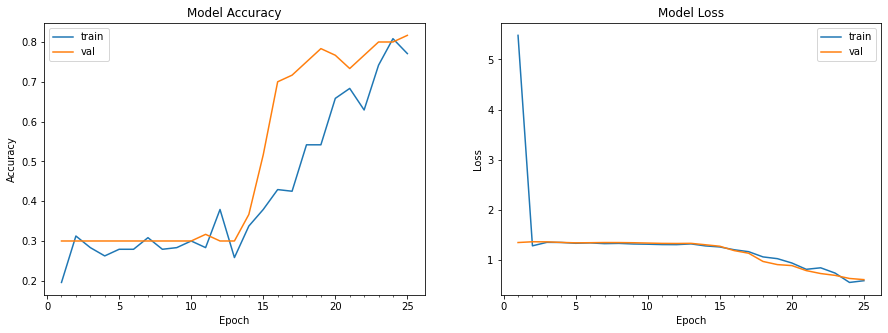

In [23]:
plot_model_history(history2)


In [24]:
loss, accuracy = model2.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


2/2 [==============================] - 0s 18ms/step - loss: 0.6068 - accuracy: 0.8167
Test: accuracy = 0.816667  ;  loss = 0.606817 


#### The accuracy and model loss improved when compared to the basic model

## <mark>Model with tanh<mark>

#### For experiments purpose, we would like to apply different activation functions to compare the results, therefore, we changed the activation function from ' relu ' to ' tanh' and check the results

In [25]:
def My_CNNmodel3():
    model = tf.keras.models.Sequential()
    model.add(InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

# 1st conv block
    model.add(Conv2D(16, (3, 3), activation='tanh', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
# 2nd conv block
    model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
# 3rd conv block
    model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
# ANN
    model.add(Flatten())
    model.add(Dense(units=512, activation='tanh'))
    model.add(Dropout(0.5))
# output layer
    model.add(Dense(units=4, activation='softmax'))

# compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model


In [26]:
model3= My_CNNmodel3()
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)       

In [27]:
history3=model3.fit(dataset_train,epochs=25,validation_data=dataset_test)

Epoch 1/25
8/8 [==============================] - 1s 93ms/step - loss: 4.4307 - accuracy: 0.3375 - val_loss: 9.0008 - val_accuracy: 0.3000
Epoch 2/25
8/8 [==============================] - 1s 81ms/step - loss: 9.9107 - accuracy: 0.0000e+00 - val_loss: 3.2304 - val_accuracy: 0.1500
Epoch 3/25
8/8 [==============================] - 1s 80ms/step - loss: 2.2113 - accuracy: 0.2708 - val_loss: 1.1416 - val_accuracy: 0.4500
Epoch 4/25
8/8 [==============================] - 1s 80ms/step - loss: 1.4698 - accuracy: 0.3958 - val_loss: 1.1185 - val_accuracy: 0.5833
Epoch 5/25
8/8 [==============================] - 1s 82ms/step - loss: 0.6626 - accuracy: 0.8083 - val_loss: 0.9085 - val_accuracy: 0.6167
Epoch 6/25
8/8 [==============================] - 1s 81ms/step - loss: 0.8576 - accuracy: 0.6500 - val_loss: 0.8992 - val_accuracy: 0.6500
Epoch 7/25
8/8 [==============================] - 1s 79ms/step - loss: 0.5707 - accuracy: 0.8167 - val_loss: 0.6096 - val_accuracy: 0.8000
Epoch 8/25
8/8 [=======

<ipython-input-18-a160c7a717b0>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1),
<ipython-input-18-a160c7a717b0>:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(


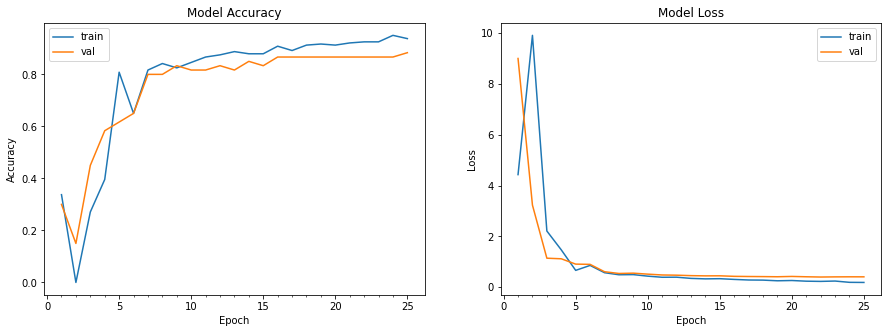

In [28]:
plot_model_history(history3)


In [29]:
loss, accuracy = model3.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


2/2 [==============================] - 0s 18ms/step - loss: 0.4083 - accuracy: 0.8833
Test: accuracy = 0.883333  ;  loss = 0.408318 


## Accuracy comparison of relu and tanh

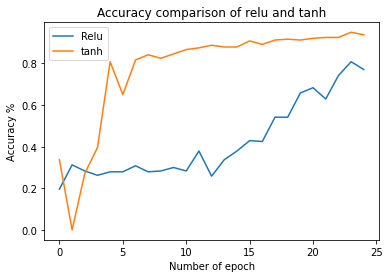

In [30]:
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.title('Accuracy comparison of relu and tanh')
plt.ylabel('Accuracy %')
plt.xlabel('Number of epoch')
plt.legend(['Relu', 'tanh'])
plt.show()


## Validation accuracy comparison of relu and tanh

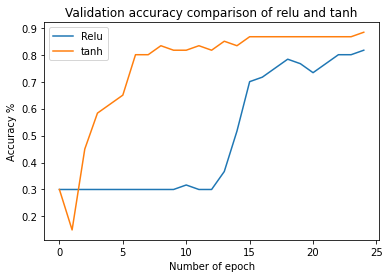

In [31]:
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Validation accuracy comparison of relu and tanh')
plt.ylabel('Accuracy %')
plt.xlabel('Number of epoch')
plt.legend(['Relu', 'tanh'])
plt.show()


## Loss comparison of relu and tanh

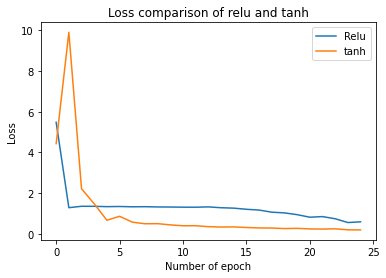

In [32]:
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.title('Loss comparison of relu and tanh')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')
plt.legend(['Relu', 'tanh'])
plt.show()


## Findings:
#### 1:From all the plots above,whether it is from the perspective of accuracy, validation accuracy and model loss, there is no huge difference between relu and tanh in our case.

## <mark>Data Augmentation<mark>


#### Image data augmentation can be used to expand the training dataset in order to improve the performance and ability of the model to generalize

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Horizontal Flip and check the image

Found 240 images belonging to 4 classes.


D:\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


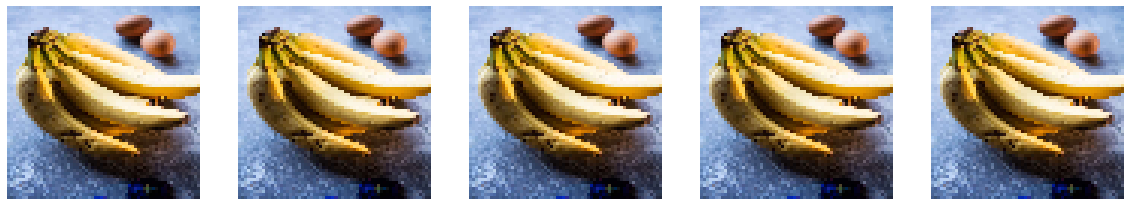

In [34]:
image_gen_flip = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen_flip.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="train_Aug",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

## Rotation and check the image

Found 240 images belonging to 4 classes.


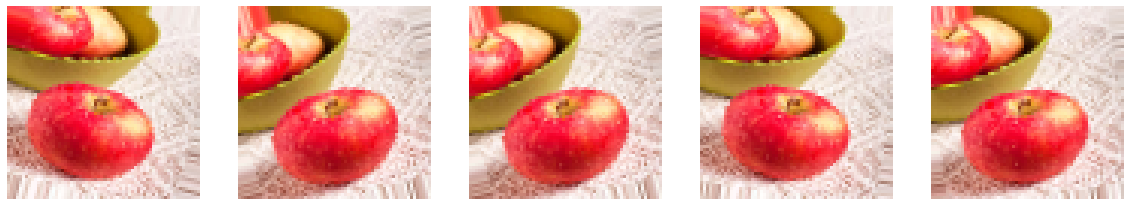

In [35]:
image_gen_rotate = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen_rotate.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory="train_Aug",
                                                      shuffle=True,
                                                      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)


## Zoom Augmentation and check the image

Found 240 images belonging to 4 classes.


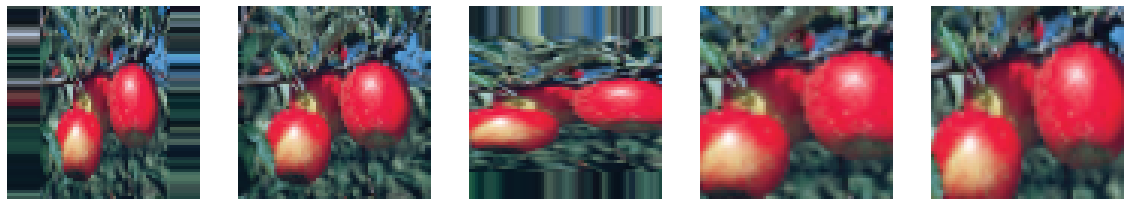

In [36]:
image_gen_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen_zoom.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="train_Aug",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)


##  Generate train data and validation data via Data Augmentation


In [37]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    horizontal_flip=True,
    zoom_range=0.3
)
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="train_Aug",
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     shuffle=True,
                                                     class_mode='categorical')
validation_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory="test_Aug",
                                                          shuffle=True,
                                                          target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                          class_mode='categorical')

Found 240 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


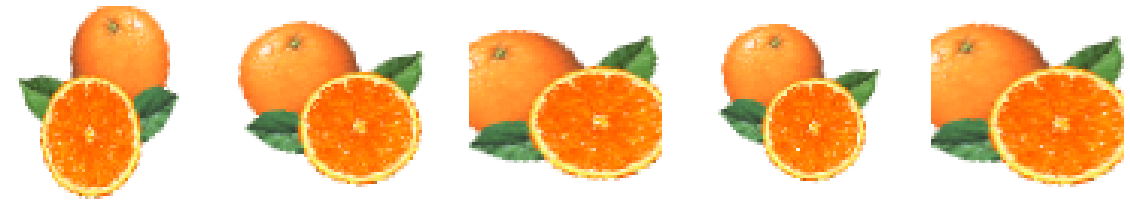

In [38]:
plotimages([train_data_gen[0][0][0] for i in range(5)])

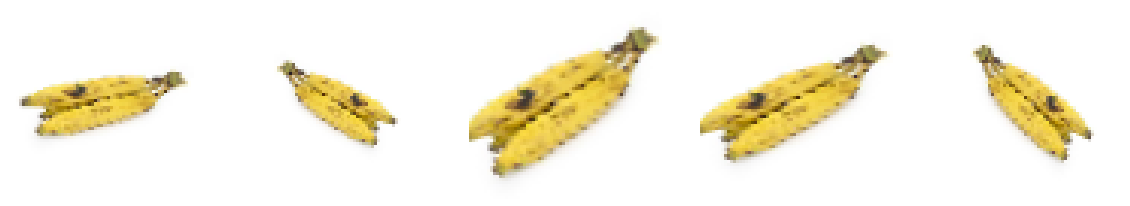

In [39]:
plotimages([validation_data_gen[0][0][0] for i in range(5)])

## Retrain the model

In [40]:
def My_CNNmodel4():
    model = tf.keras.models.Sequential()
    model.add(InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))


# 1st conv block
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
# 2nd conv block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
# 3rd conv block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
# ANN
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.5))
# output layer
    model.add(Dense(units=4, activation='softmax'))

# compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model


In [41]:
new_model = My_CNNmodel4()
new_hist=new_model.fit_generator(train_data_gen,epochs=25,validation_data=validation_data_gen)

<ipython-input-41-34e63ecf1916>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_hist=new_model.fit_generator(train_data_gen,epochs=25,validation_data=validation_data_gen)


Epoch 1/25
8/8 [==============================] - 4s 435ms/step - loss: 1.3016 - accuracy: 0.3708 - val_loss: 1.1848 - val_accuracy: 0.6167
Epoch 2/25
8/8 [==============================] - 3s 364ms/step - loss: 1.0163 - accuracy: 0.5917 - val_loss: 0.9366 - val_accuracy: 0.7500
Epoch 3/25
8/8 [==============================] - 3s 385ms/step - loss: 0.7799 - accuracy: 0.7375 - val_loss: 0.6978 - val_accuracy: 0.8167
Epoch 4/25
8/8 [==============================] - 3s 387ms/step - loss: 0.5994 - accuracy: 0.7833 - val_loss: 0.7153 - val_accuracy: 0.8000
Epoch 5/25
8/8 [==============================] - 3s 378ms/step - loss: 0.5006 - accuracy: 0.8208 - val_loss: 0.6438 - val_accuracy: 0.8167
Epoch 6/25
8/8 [==============================] - 3s 366ms/step - loss: 0.4398 - accuracy: 0.8500 - val_loss: 0.5314 - val_accuracy: 0.8167
Epoch 7/25
8/8 [==============================] - 3s 372ms/step - loss: 0.3935 - accuracy: 0.8625 - val_loss: 0.5511 - val_accuracy: 0.8500
Epoch 8/25
8/8 [====

<ipython-input-18-a160c7a717b0>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1),
<ipython-input-18-a160c7a717b0>:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(


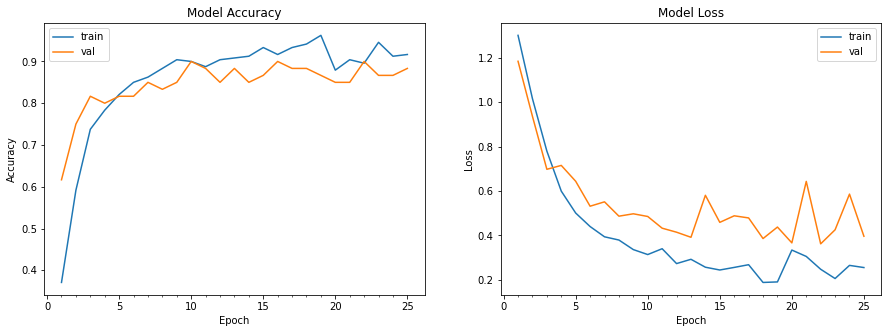

In [42]:
plot_model_history(new_hist)


## Evaluation

In [43]:
loss, accuracy = new_model.evaluate(validation_data_gen)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


2/2 [==============================] - 1s 322ms/step - loss: 0.3959 - accuracy: 0.9000
Test: accuracy = 0.900000  ;  loss = 0.395891 


In [44]:
new_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)       